In [12]:
listData=['book2.jpg', 'dog.jpg']
listTitle=['책', '개']

In [58]:
listData = [{'id':0, 'img':'book2.jpg', 'title':'책'},
            {'id':1, 'img':'dog.jpg', 'title':'개'},
            {'id':2, 'img':'person.jpg', 'title':'사람'}]

In [59]:
listData[0]['id']

0

In [60]:
for s in listData:
    if s['id']==1:
        listData.remove(s)

listData

[{'id': 0, 'img': 'book2.jpg', 'title': '책'},
 {'id': 2, 'img': 'person.jpg', 'title': '사람'}]

In [61]:
import cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt


# Initialize the parameters

# Confidence threshold 0.5 이하인것은 다 날림.
confThreshold = 0.5 
# Non-maximum suppression threshold 
# 거리가 떨어져 있는것을 하나로 볼것인지 여부. 
# 주변보다 상대적으로 높거나 낮은 것들만 살리고 아닌것들은 버림.
nmsThreshold = 0.4 
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()] #3개의 yolo 출력층 index 리턴

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:] # 80개의 확률값들 가져오기
            classId = np.argmax(scores) # 가장 높은 확률값 가져오기
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
#     print(len(boxes))
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
#     print(len(indices))
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

cap = cv2.VideoCapture('yellow.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))



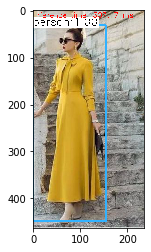

In [75]:
cv2.imwrite("out.png", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)